# Vinyl Foam Mastercurve (auto TTS)

Use vinyl foam DMA sweeps across temperature to auto-build a mastercurve and fit models.

**Data:** examples/data/pyRheo/vinyl_foam/foam_dma_*C.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 17:30:10,660:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load multi-temperature sweeps

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'vinyl_foam'
files = sorted(DATA_DIR.glob('foam_dma_*C.csv'))

datasets = []
for fpath in files:
    temp_str = fpath.stem.split('_')[-1].replace('C','')
    temp_c = float(temp_str.replace('--','-') or 0)
    df = pd.read_csv(fpath, sep='	')
    df.columns = df.columns.str.strip()
    omega = df['Angular Frequency'].to_numpy()  # rad/s
    Gp = df['Storage Modulus'].to_numpy()
    Gpp = df['Loss Modulus'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15}))

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.184841s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1137 | final_cost=2.847635e-05 | time=3.185s | final_gradient_norm=1.9593678066536493


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.065809s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1546 | final_cost=7.318832e-06 | time=3.066s | final_gradient_norm=4.681133328683614


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.259078s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1107 | final_cost=9.143014e-05 | time=2.259s | final_gradient_norm=4.942920114650096


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.529366s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1284 | final_cost=3.478873e-05 | time=2.529s | final_gradient_norm=5.504286342945557


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.278589s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1141 | final_cost=7.394126e-05 | time=2.279s | final_gradient_norm=10.056073311473455


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.674648s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1340 | final_cost=3.532695e-05 | time=2.675s | final_gradient_norm=6.769760690268101


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.105423s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1057 | final_cost=1.826033e-04 | time=2.105s | final_gradient_norm=14.131309467743717


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.557239s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1353 | final_cost=9.668900e-05 | time=2.557s | final_gradient_norm=3.1775047678020822


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.330613s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1180 | final_cost=2.290538e-04 | time=2.331s | final_gradient_norm=13.379307727787848


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.806400s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1422 | final_cost=9.390506e-05 | time=2.806s | final_gradient_norm=1.1678278408194886


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.291539s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1224 | final_cost=2.732868e-04 | time=2.292s | final_gradient_norm=9.249384848789871


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.780242s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1498 | final_cost=1.121638e-04 | time=2.780s | final_gradient_norm=4.923118158747282


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 2.959672s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1507 | final_cost=3.291866e-04 | time=2.960s | final_gradient_norm=0.10395682878995915


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 3.349547s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=1756 | final_cost=1.515900e-04 | time=3.350s | final_gradient_norm=0.9973448360220061


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 4.150810s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=2334 | final_cost=5.237152e-05 | time=4.151s | final_gradient_norm=1.811542610485294


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 5.398866s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=2828 | final_cost=1.537233e-05 | time=5.399s | final_gradient_norm=0.04596603100312843


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.174389s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=10 | final_cost=6.020703e-06 | time=0.174s | final_gradient_norm=4.296248934577283e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.186311s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=14 | final_cost=6.006202e-06 | time=0.186s | final_gradient_norm=0.3318624878452313


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.178012s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=12 | final_cost=5.484181e-06 | time=0.178s | final_gradient_norm=6.2835244692127e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.214463s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=27 | final_cost=4.776305e-06 | time=0.214s | final_gradient_norm=2.2890066320307968e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.186963s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=14 | final_cost=1.378606e-05 | time=0.187s | final_gradient_norm=0.0020447958774599947


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.230534s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=35 | final_cost=6.040234e-06 | time=0.231s | final_gradient_norm=1.5794995436200478e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.176796s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=2.104074e-05 | time=0.177s | final_gradient_norm=0.011968817985013905


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.199795s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=6.741094e-06 | time=0.200s | final_gradient_norm=2.357875827101456e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.174421s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=1.984566e-06 | time=0.174s | final_gradient_norm=3.589858867217507e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.173878s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1.866241e-06 | time=0.174s | final_gradient_norm=2.1122693962855353e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.131132s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=9 | final_cost=4.920777e-05 | time=0.131s | final_gradient_norm=4.4753090025047414e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180575s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=3.252937e-05 | time=0.181s | final_gradient_norm=0.0001383206606126514


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.139940s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=5.539998e-05 | time=0.140s | final_gradient_norm=0.00035744967928987345


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.131168s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=1.461781e-05 | time=0.131s | final_gradient_norm=0.00011525856058986563


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.184922s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=15 | final_cost=1.854740e-05 | time=0.185s | final_gradient_norm=4.141788472671135e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.204737s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=1.844149e-05 | time=0.205s | final_gradient_norm=0.0023764463792100322


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.197378s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=1.260871e-04 | time=0.197s | final_gradient_norm=4.115960352902374


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.209235s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=2.781481e-05 | time=0.209s | final_gradient_norm=0.06322913347243793


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.203371s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=24 | final_cost=2.234716e-04 | time=0.203s | final_gradient_norm=0.6339786502414594


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.200368s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=3.796443e-05 | time=0.200s | final_gradient_norm=5.7969977989433135


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.207597s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=27 | final_cost=5.400780e-04 | time=0.208s | final_gradient_norm=34.7794298901261


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.215645s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=3.383210e-05 | time=0.216s | final_gradient_norm=0.04343451130040529


Temps (C): [-10.0, -15.0, -20.0, -25.0, -30.0, -35.0, -5.0, 0.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 5.0, 60.0]


## Plot raw vs shifted

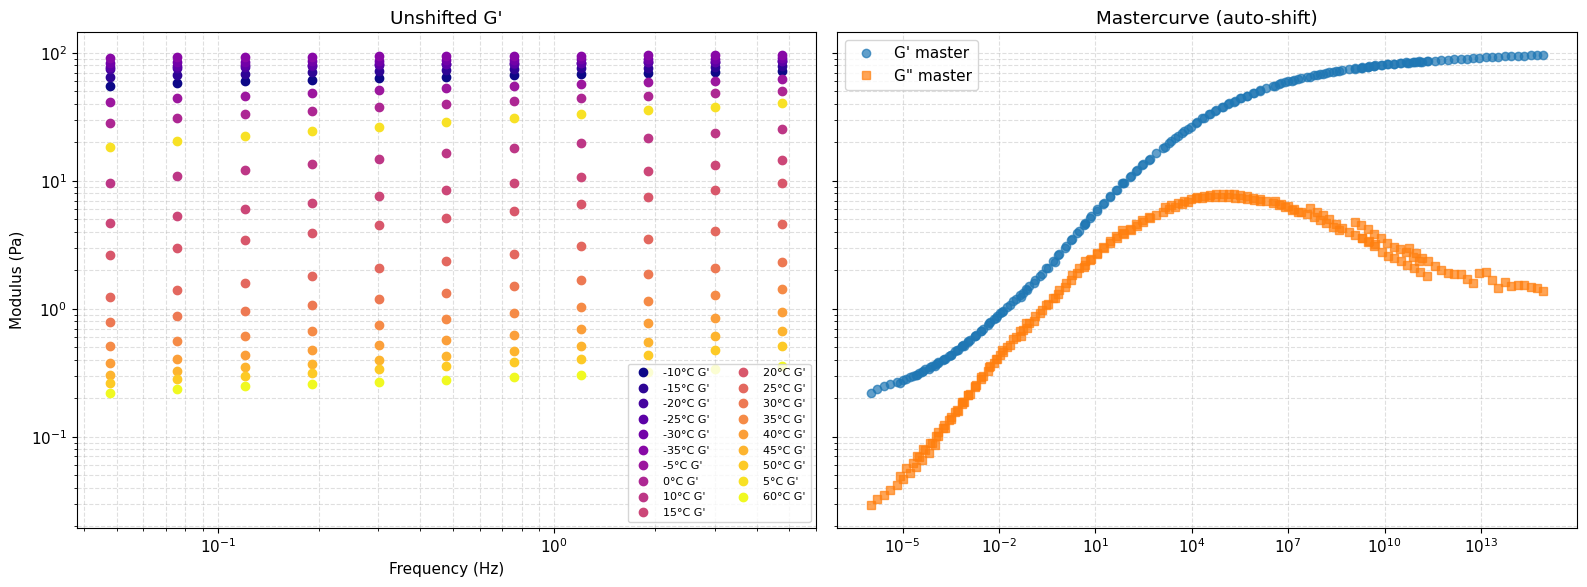

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.plasma(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.881127s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=37 | final_cost=9.251854e+03 | time=0.881s | final_gradient_norm=6.055302737246656


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.317803s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=37 | final_cost=9.251854e+03 | time=0.318s | final_gradient_norm=6.055302737246656


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.858368s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=9.275799e+03 | time=0.858s | final_gradient_norm=1456778076.7605355


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.884296s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=9.379602e+03 | time=0.884s | final_gradient_norm=4758339426.218957


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.834481s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=9.958490e+03 | time=0.834s | final_gradient_norm=6747478561.9496975


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.204270s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=4 | final_cost=1.559144e+04 | time=0.204s | final_gradient_norm=0.049085348239427395


Element minimization: early termination at n_modes=1 (R²=0.913460 < threshold=0.922971)


Element minimization: reducing from 5 to 2 modes


Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.047075s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=58 | final_cost=1.061725e+02 | time=1.047s | final_gradient_norm=21875857.55827278


{'gm_r2': 0.9235943069771968, 'fm_r2': -0.39260472953777925}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.228134s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=17 | final_cost=4.246888e-04 | time=0.228s | final_gradient_norm=6.19139746135334e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.224052s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=17 | final_cost=4.246888e-04 | time=0.224s | final_gradient_norm=6.19139746135334e-07


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.185319s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=3.884822e-03 | time=0.185s | final_gradient_norm=35.25062842256163


Element minimization: early termination at n_modes=1 (R²=0.975800 < threshold=0.996032)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.282177s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=1.688533e-01 | time=0.282s | final_gradient_norm=0.0011992692847039312


Model ranking (R²): [('gm', 0.962), ('fm', 0.916)]


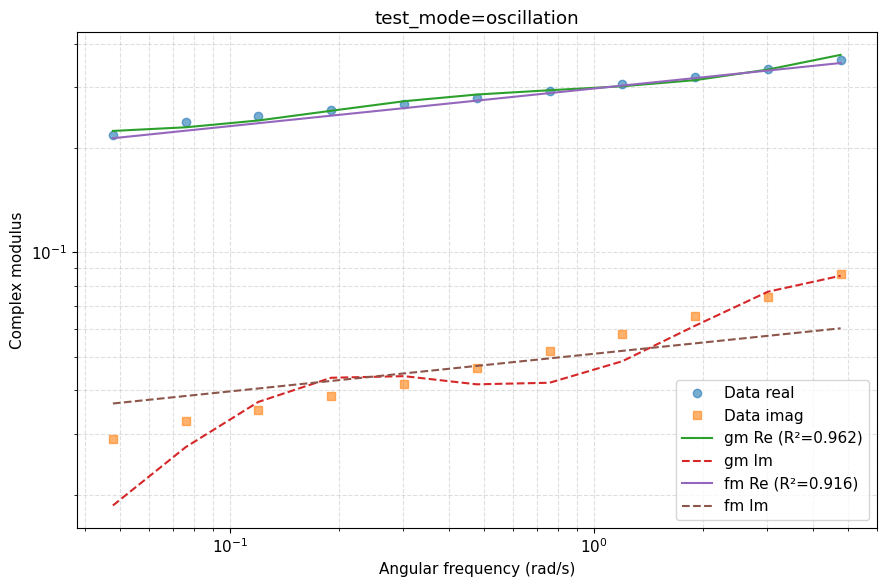

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<45:08,  1.48it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   3%|▎         | 135/4000 [00:00<00:16, 234.19it/s, 255 steps of size 5.31e-02. acc. prob=0.77]

warmup:   7%|▋         | 299/4000 [00:00<00:07, 513.32it/s, 31 steps of size 1.96e-01. acc. prob=0.78] 

warmup:  13%|█▎        | 508/4000 [00:00<00:04, 861.59it/s, 63 steps of size 9.07e-02. acc. prob=0.79]

warmup:  19%|█▊        | 747/4000 [00:01<00:02, 1227.40it/s, 15 steps of size 2.20e-01. acc. prob=0.79]

warmup:  25%|██▍       | 983/4000 [00:01<00:01, 1515.44it/s, 15 steps of size 4.04e-01. acc. prob=0.79]

sample:  30%|███       | 1205/4000 [00:01<00:01, 1703.19it/s, 15 steps of size 2.01e-01. acc. prob=0.94]

sample:  36%|███▌      | 1427/4000 [00:01<00:01, 1845.74it/s, 15 steps of size 2.01e-01. acc. prob=0.94]

sample:  41%|████▏     | 1655/4000 [00:01<00:01, 1966.81it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  47%|████▋     | 1884/4000 [00:01<00:01, 2057.23it/s, 31 steps of size 2.01e-01. acc. prob=0.92]

sample:  53%|█████▎    | 2109/4000 [00:01<00:00, 2113.12it/s, 31 steps of size 2.01e-01. acc. prob=0.92]

sample:  59%|█████▊    | 2342/4000 [00:01<00:00, 2176.22it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  64%|██████▍   | 2572/4000 [00:01<00:00, 2212.17it/s, 15 steps of size 2.01e-01. acc. prob=0.92]

sample:  70%|███████   | 2808/4000 [00:01<00:00, 2254.80it/s, 47 steps of size 2.01e-01. acc. prob=0.91]

sample:  76%|███████▌  | 3038/4000 [00:02<00:00, 2263.56it/s, 31 steps of size 2.01e-01. acc. prob=0.91]

sample:  82%|████████▏ | 3268/4000 [00:02<00:00, 2266.92it/s, 31 steps of size 2.01e-01. acc. prob=0.91]

sample:  88%|████████▊ | 3504/4000 [00:02<00:00, 2293.46it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample:  93%|█████████▎| 3735/4000 [00:02<00:00, 2276.94it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample:  99%|█████████▉| 3975/4000 [00:02<00:00, 2312.68it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1601.51it/s, 15 steps of size 2.01e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   4%|▍         | 150/4000 [00:00<00:02, 1498.28it/s, 7 steps of size 3.15e-01. acc. prob=0.78]

warmup:   9%|▉         | 370/4000 [00:00<00:01, 1904.34it/s, 31 steps of size 1.98e-01. acc. prob=0.78]

warmup:  15%|█▍        | 585/4000 [00:00<00:01, 2015.89it/s, 5 steps of size 2.09e-01. acc. prob=0.79] 

warmup:  21%|██        | 837/4000 [00:00<00:01, 2213.75it/s, 7 steps of size 4.48e-01. acc. prob=0.79]

sample:  26%|██▋       | 1059/4000 [00:00<00:01, 2205.44it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  33%|███▎      | 1305/4000 [00:00<00:01, 2289.48it/s, 15 steps of size 2.30e-01. acc. prob=0.89]

sample:  38%|███▊      | 1537/4000 [00:00<00:01, 2298.99it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  44%|████▍     | 1777/4000 [00:00<00:00, 2329.75it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  50%|█████     | 2018/4000 [00:00<00:00, 2353.21it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  56%|█████▋    | 2257/4000 [00:01<00:00, 2364.15it/s, 15 steps of size 2.30e-01. acc. prob=0.90]

sample:  62%|██████▏   | 2494/4000 [00:01<00:00, 2365.37it/s, 7 steps of size 2.30e-01. acc. prob=0.90] 

sample:  68%|██████▊   | 2735/4000 [00:01<00:00, 2377.80it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  74%|███████▍  | 2979/4000 [00:01<00:00, 2393.63it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  80%|████████  | 3219/4000 [00:01<00:00, 2388.87it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  86%|████████▋ | 3458/4000 [00:01<00:00, 2384.56it/s, 31 steps of size 2.30e-01. acc. prob=0.91]

sample:  92%|█████████▏| 3697/4000 [00:01<00:00, 2379.26it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample:  98%|█████████▊| 3936/4000 [00:01<00:00, 2381.38it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2307.06it/s, 15 steps of size 2.30e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   4%|▍         | 166/4000 [00:00<00:02, 1657.53it/s, 31 steps of size 1.56e-01. acc. prob=0.78]

warmup:  10%|▉         | 393/4000 [00:00<00:01, 2015.43it/s, 7 steps of size 4.06e-01. acc. prob=0.79] 

warmup:  16%|█▌        | 629/4000 [00:00<00:01, 2171.63it/s, 15 steps of size 2.45e-01. acc. prob=0.79]

warmup:  22%|██▏       | 881/4000 [00:00<00:01, 2307.91it/s, 15 steps of size 2.39e-01. acc. prob=0.79]

sample:  28%|██▊       | 1117/4000 [00:00<00:01, 2326.48it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  34%|███▍      | 1350/4000 [00:00<00:01, 2326.48it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  40%|███▉      | 1591/4000 [00:00<00:01, 2353.46it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  46%|████▌     | 1832/4000 [00:00<00:00, 2370.08it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  52%|█████▏    | 2073/4000 [00:00<00:00, 2380.68it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  58%|█████▊    | 2317/4000 [00:01<00:00, 2395.89it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  64%|██████▍   | 2560/4000 [00:01<00:00, 2405.17it/s, 15 steps of size 2.24e-01. acc. prob=0.92]

sample:  70%|███████   | 2801/4000 [00:01<00:00, 2388.46it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  76%|███████▌  | 3040/4000 [00:01<00:00, 2366.63it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  82%|████████▏ | 3277/4000 [00:01<00:00, 2237.41it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  88%|████████▊ | 3518/4000 [00:01<00:00, 2284.37it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample:  94%|█████████▍| 3763/4000 [00:01<00:00, 2331.02it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2316.05it/s, 15 steps of size 2.24e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 117/4000 [00:00<00:03, 1139.99it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:   6%|▌         | 241/4000 [00:00<00:03, 1196.40it/s, 31 steps of size 1.21e-01. acc. prob=0.78] 

warmup:  12%|█▏        | 465/4000 [00:00<00:02, 1665.61it/s, 31 steps of size 3.06e-01. acc. prob=0.79]

warmup:  17%|█▋        | 675/4000 [00:00<00:01, 1834.27it/s, 31 steps of size 9.16e-02. acc. prob=0.79]

warmup:  23%|██▎       | 907/4000 [00:00<00:01, 2007.00it/s, 15 steps of size 2.17e-01. acc. prob=0.79]

sample:  28%|██▊       | 1118/4000 [00:00<00:01, 2038.80it/s, 31 steps of size 1.89e-01. acc. prob=0.95]

sample:  33%|███▎      | 1322/4000 [00:00<00:01, 2036.12it/s, 31 steps of size 1.89e-01. acc. prob=0.95]

sample:  38%|███▊      | 1531/4000 [00:00<00:01, 2050.63it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  44%|████▎     | 1741/4000 [00:00<00:01, 2063.83it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  49%|████▉     | 1952/4000 [00:01<00:00, 2075.64it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  54%|█████▍    | 2162/4000 [00:01<00:00, 2081.24it/s, 63 steps of size 1.89e-01. acc. prob=0.94]

sample:  59%|█████▉    | 2376/4000 [00:01<00:00, 2097.89it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  65%|██████▍   | 2591/4000 [00:01<00:00, 2112.62it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  70%|███████   | 2811/4000 [00:01<00:00, 2137.11it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  76%|███████▌  | 3025/4000 [00:01<00:00, 2114.09it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  81%|████████  | 3246/4000 [00:01<00:00, 2140.94it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample:  87%|████████▋ | 3461/4000 [00:01<00:00, 2110.88it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  92%|█████████▏| 3673/4000 [00:01<00:00, 2108.14it/s, 31 steps of size 1.89e-01. acc. prob=0.94]

sample:  97%|█████████▋| 3887/4000 [00:01<00:00, 2116.81it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2028.59it/s, 15 steps of size 1.89e-01. acc. prob=0.94]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.320121s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=43 | final_cost=9.958485e+03 | time=0.320s | final_gradient_norm=2.148907538490507


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.303882s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=43 | final_cost=9.958485e+03 | time=0.304s | final_gradient_norm=2.148907538490507


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.217725s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=1.559144e+04 | time=0.218s | final_gradient_norm=0.0500744771296501


Element minimization: early termination at n_modes=1 (R²=0.913460 < threshold=0.917088)


Auto-enabling multi-start optimization for very wide range (20.9 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.414933s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=58 | final_cost=1.061725e+02 | time=0.415s | final_gradient_norm=21875857.55827278


Model ranking (R²): [('gm', 0.924), ('fm', -0.393)]


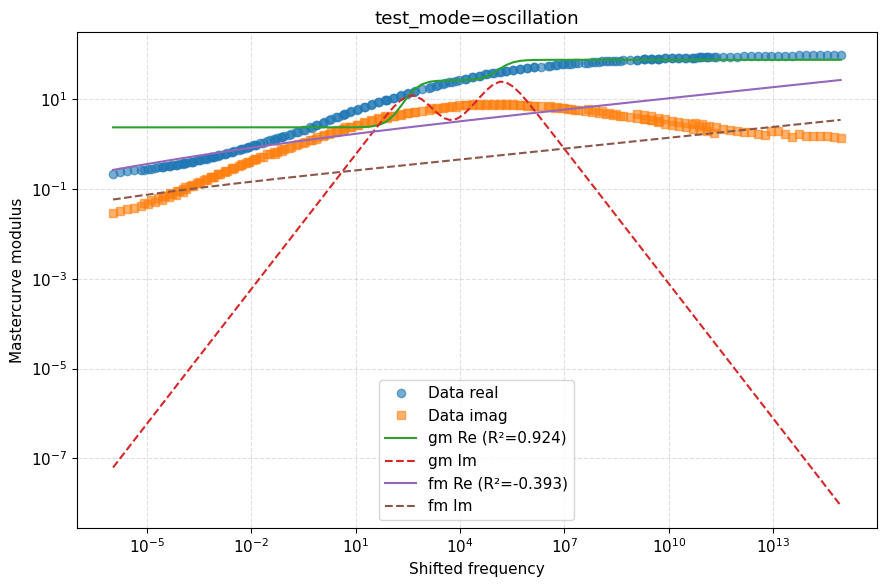

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<44:17,  1.50it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 57/4000 [00:00<00:39, 99.31it/s, 511 steps of size 1.93e-02. acc. prob=0.75]

warmup:   4%|▍         | 167/4000 [00:00<00:12, 299.49it/s, 7 steps of size 1.70e-01. acc. prob=0.78]

warmup:   9%|▊         | 344/4000 [00:00<00:05, 625.74it/s, 15 steps of size 2.88e-01. acc. prob=0.78]

warmup:  15%|█▍        | 582/4000 [00:01<00:03, 1047.55it/s, 7 steps of size 3.07e-01. acc. prob=0.79]

warmup:  21%|██        | 833/4000 [00:01<00:02, 1420.36it/s, 15 steps of size 2.82e-01. acc. prob=0.79]

sample:  27%|██▋       | 1077/4000 [00:01<00:01, 1691.62it/s, 15 steps of size 2.87e-01. acc. prob=0.93]

sample:  33%|███▎      | 1312/4000 [00:01<00:01, 1873.50it/s, 15 steps of size 2.87e-01. acc. prob=0.92]

sample:  39%|███▊      | 1548/4000 [00:01<00:01, 2008.73it/s, 15 steps of size 2.87e-01. acc. prob=0.92]

sample:  45%|████▍     | 1781/4000 [00:01<00:01, 2098.80it/s, 15 steps of size 2.87e-01. acc. prob=0.92]

sample:  50%|█████     | 2016/4000 [00:01<00:00, 2171.60it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  56%|█████▌    | 2248/4000 [00:01<00:00, 2214.09it/s, 15 steps of size 2.87e-01. acc. prob=0.92]

sample:  62%|██████▏   | 2485/4000 [00:01<00:00, 2258.98it/s, 7 steps of size 2.87e-01. acc. prob=0.92] 

sample:  68%|██████▊   | 2719/4000 [00:01<00:00, 2280.90it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  74%|███████▍  | 2951/4000 [00:02<00:00, 2288.69it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  80%|███████▉  | 3183/4000 [00:02<00:00, 2280.14it/s, 7 steps of size 2.87e-01. acc. prob=0.91] 

sample:  86%|████████▌ | 3420/4000 [00:02<00:00, 2305.41it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  91%|█████████▏| 3657/4000 [00:02<00:00, 2322.80it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample:  97%|█████████▋| 3896/4000 [00:02<00:00, 2340.71it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1586.41it/s, 15 steps of size 2.87e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 63/4000 [00:00<00:06, 609.81it/s, 255 steps of size 2.15e-02. acc. prob=0.76]

warmup:   4%|▍         | 167/4000 [00:00<00:04, 858.84it/s, 31 steps of size 2.23e-01. acc. prob=0.78]

warmup:  10%|▉         | 397/4000 [00:00<00:02, 1509.80it/s, 15 steps of size 2.43e-01. acc. prob=0.79]

warmup:  16%|█▌        | 632/4000 [00:00<00:01, 1837.68it/s, 15 steps of size 4.01e-01. acc. prob=0.79]

warmup:  22%|██▏       | 897/4000 [00:00<00:01, 2126.11it/s, 15 steps of size 3.10e-01. acc. prob=0.79]

sample:  28%|██▊       | 1110/4000 [00:00<00:01, 2032.30it/s, 15 steps of size 2.23e-01. acc. prob=0.91]

sample:  33%|███▎      | 1329/4000 [00:00<00:01, 2081.13it/s, 15 steps of size 2.23e-01. acc. prob=0.93]

sample:  39%|███▉      | 1550/4000 [00:00<00:01, 2120.52it/s, 7 steps of size 2.23e-01. acc. prob=0.94] 

sample:  44%|████▍     | 1772/4000 [00:00<00:01, 2147.92it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  50%|████▉     | 1993/4000 [00:01<00:00, 2165.06it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  55%|█████▌    | 2212/4000 [00:01<00:00, 2172.33it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  61%|██████    | 2430/4000 [00:01<00:00, 2170.16it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  66%|██████▌   | 2648/4000 [00:01<00:00, 2165.28it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  72%|███████▏  | 2865/4000 [00:01<00:00, 2157.62it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  77%|███████▋  | 3087/4000 [00:01<00:00, 2172.86it/s, 31 steps of size 2.23e-01. acc. prob=0.94]

sample:  83%|████████▎ | 3306/4000 [00:01<00:00, 2176.82it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  88%|████████▊ | 3524/4000 [00:01<00:00, 2167.41it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  94%|█████████▎| 3744/4000 [00:01<00:00, 2174.74it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

sample:  99%|█████████▉| 3967/4000 [00:01<00:00, 2186.68it/s, 31 steps of size 2.23e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2059.14it/s, 15 steps of size 2.23e-01. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 65/4000 [00:00<00:06, 643.99it/s, 95 steps of size 4.85e-02. acc. prob=0.76]

warmup:   5%|▍         | 193/4000 [00:00<00:03, 1016.48it/s, 3 steps of size 1.99e-01. acc. prob=0.78]

warmup:  11%|█         | 438/4000 [00:00<00:02, 1668.90it/s, 15 steps of size 3.85e-01. acc. prob=0.79]

warmup:  17%|█▋        | 684/4000 [00:00<00:01, 1980.45it/s, 7 steps of size 2.99e-01. acc. prob=0.79] 

warmup:  24%|██▍       | 961/4000 [00:00<00:01, 2263.22it/s, 7 steps of size 4.26e-01. acc. prob=0.79]

sample:  30%|███       | 1215/4000 [00:00<00:01, 2356.86it/s, 7 steps of size 3.65e-01. acc. prob=0.78]

sample:  37%|███▋      | 1474/4000 [00:00<00:01, 2432.16it/s, 15 steps of size 3.65e-01. acc. prob=0.78]

sample:  43%|████▎     | 1738/4000 [00:00<00:00, 2497.49it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  50%|████▉     | 1999/4000 [00:00<00:00, 2532.46it/s, 7 steps of size 3.65e-01. acc. prob=0.80] 

sample:  56%|█████▋    | 2255/4000 [00:01<00:00, 2537.41it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  63%|██████▎   | 2511/4000 [00:01<00:00, 2542.01it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  69%|██████▉   | 2772/4000 [00:01<00:00, 2560.71it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  76%|███████▌  | 3029/4000 [00:01<00:00, 2528.17it/s, 23 steps of size 3.65e-01. acc. prob=0.80]

sample:  82%|████████▏ | 3283/4000 [00:01<00:00, 2529.73it/s, 15 steps of size 3.65e-01. acc. prob=0.80]

sample:  88%|████████▊ | 3538/4000 [00:01<00:00, 2535.02it/s, 7 steps of size 3.65e-01. acc. prob=0.81] 

sample:  95%|█████████▍| 3792/4000 [00:01<00:00, 2535.55it/s, 15 steps of size 3.65e-01. acc. prob=0.81]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2366.88it/s, 7 steps of size 3.65e-01. acc. prob=0.81] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 47/4000 [00:00<00:08, 467.55it/s, 59 steps of size 1.28e-02. acc. prob=0.74]

warmup:   3%|▎         | 107/4000 [00:00<00:07, 544.81it/s, 11 steps of size 7.38e-01. acc. prob=0.77]

warmup:   7%|▋         | 280/4000 [00:00<00:03, 1084.56it/s, 15 steps of size 2.56e-01. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [00:00<00:02, 1553.56it/s, 15 steps of size 3.66e-01. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:00<00:01, 1855.90it/s, 11 steps of size 2.88e-01. acc. prob=0.79]

warmup:  25%|██▍       | 985/4000 [00:00<00:01, 2030.08it/s, 7 steps of size 5.31e-01. acc. prob=0.79] 

sample:  30%|██▉       | 1191/4000 [00:00<00:01, 2039.78it/s, 7 steps of size 2.67e-01. acc. prob=0.93]

sample:  35%|███▌      | 1414/4000 [00:00<00:01, 2099.54it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  41%|████      | 1638/4000 [00:00<00:01, 2139.71it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  46%|████▋     | 1852/4000 [00:01<00:01, 2138.13it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  52%|█████▏    | 2076/4000 [00:01<00:00, 2167.34it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  57%|█████▋    | 2293/4000 [00:01<00:00, 2090.66it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  63%|██████▎   | 2511/4000 [00:01<00:00, 2116.24it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  68%|██████▊   | 2724/4000 [00:01<00:00, 2114.54it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  73%|███████▎  | 2936/4000 [00:01<00:00, 2103.91it/s, 7 steps of size 2.67e-01. acc. prob=0.93] 

sample:  79%|███████▉  | 3152/4000 [00:01<00:00, 2118.82it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  84%|████████▍ | 3377/4000 [00:01<00:00, 2155.95it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  90%|████████▉ | 3594/4000 [00:01<00:00, 2158.21it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample:  95%|█████████▌| 3817/4000 [00:01<00:00, 2177.48it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1998.72it/s, 15 steps of size 2.67e-01. acc. prob=0.93]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
